## Visual Search Engine

A comprehensive visual search engine implementation using deep learning and similarity search, built for both general image search and face recognition tasks.

This notebook covers

- **ResNet101 Embeddings**: 2048-dimensional feature vectors from pretrained ImageNet model
- **FAISS Search Index**: Efficient L2 distance similarity search  
- **Prototype with TinyImageNet**: A dataset with 1L images and 200 classes
- **Face Search Extension**: CelebA dataset
- **Comprehensive Evaluation**: Precision@k, Recall@k, mAP metrics

**Import libraries**

In [11]:
from utils import *
import torch
from face_search_extension import CelebADataset, evaluate_face_search, get_face_transforms, face_search_and_visualize

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Load Tiny imagenet dataset**

In [2]:
train_dataset = TinyImageNetDataset("data/tiny-imagenet-200", 'train', get_transforms('train'))
val_dataset = TinyImageNetDataset("data/tiny-imagenet-200", 'val', get_transforms('val'))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

**Load RESNET101 embeddings (2048 dim)**

In [3]:
model = ResNetEmbedder(pretrained=True)
embeddings, labels, paths = extract_embeddings(model, train_loader, device)

/workspace/repo/dl-lab-notebooks/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/workspace/repo/dl-lab-notebooks/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Extracting embeddings...


100%|██████████| 3125/3125 [02:52<00:00, 18.12it/s]


Extracted 100000 embeddings of dimension 2048


**Build a search index**

In [4]:
index = FAISSIndex()
index.build_index(embeddings, labels, paths)

Building FAISS index...


Index built with 100000 vectors


**Evaluate search results**

In [5]:
results = evaluate_search_engine(model, index, val_dataset, device, num_queries = 500, k_values = [1, 5, 10])

Evaluating with 500 queries...


100%|██████████| 500/500 [00:37<00:00, 13.24it/s]


Precision@1: 0.6460
Recall@1: 0.0013
mAP@1: 0.6460
------------------------------
Precision@5: 0.5956
Recall@5: 0.0060
mAP@5: 0.6896
------------------------------
Precision@10: 0.5780
Recall@10: 0.0116
mAP@10: 0.6678
------------------------------


- The recall is very low, due to the fact that the number of samples per class is 500, so the maximum Top-5 recall can be 0.01 (5/500)
- The precision and mAP are under acceptable range, considering we have not fine tuned before extracting the embeddings.

**Visualize Top-5 search results**

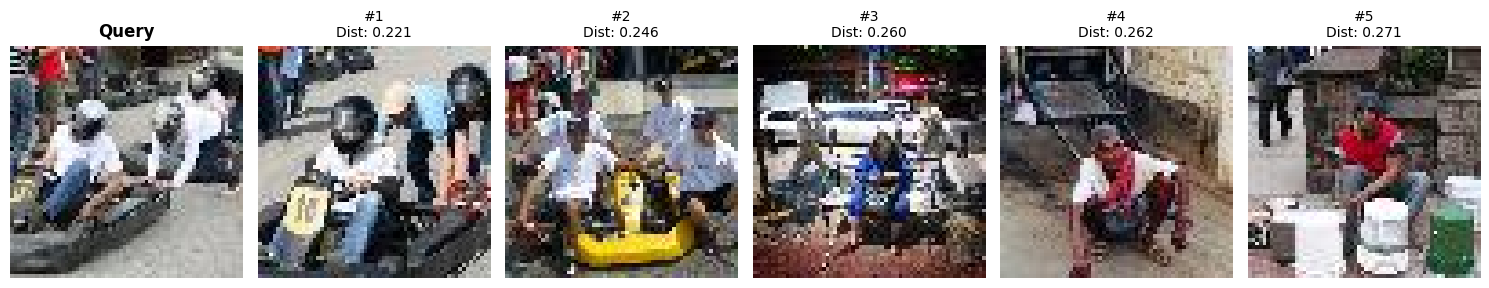

(['data/tiny-imagenet-200/train/n03444034/images/n03444034_357.JPEG',
  'data/tiny-imagenet-200/train/n03444034/images/n03444034_135.JPEG',
  'data/tiny-imagenet-200/train/n03670208/images/n03670208_334.JPEG',
  'data/tiny-imagenet-200/train/n03599486/images/n03599486_95.JPEG',
  'data/tiny-imagenet-200/train/n02909870/images/n02909870_175.JPEG'],
 array([0.22100838, 0.24611242, 0.26016062, 0.26203537, 0.27103108],
       dtype=float32),
 array([53551, 53970, 58256, 55857, 40320]))

In [7]:
query_path = val_dataset.image_paths[0]
search_and_visualize(model, index, query_path, device, k=5)

**Load CelebA face dataset**

In [8]:
# Setup face dataset (requires CelebA download)
face_dataset = CelebADataset('data/img_align_celeba', 'val', get_face_transforms('val'))
face_loader = DataLoader(face_dataset, batch_size=32, shuffle=False)

Loading split information...
Loading attributes information...
Using 'Male' as target attribute


Loaded 19867 images from val split
Target attribute 'Male' distribution:
  0: 11409 images (57.4%)
  1: 8458 images (42.6%)


**Load RESNET101 embedding and build index**

In [9]:
face_embeddings, face_labels, face_paths = extract_embeddings(model, face_loader, device)
face_index = FAISSIndex()
face_index.build_index(face_embeddings, face_labels, face_paths)

Extracting embeddings...


100%|██████████| 621/621 [00:42<00:00, 14.52it/s]


Extracted 19867 embeddings of dimension 2048
Building FAISS index...
Index built with 19867 vectors


**Evaluate search results**

In [10]:
face_results = evaluate_face_search(model, face_index, face_dataset, device)

Evaluating face search with 100 queries...


  5%|▌         | 5/100 [00:00<00:05, 18.83it/s]

100%|██████████| 100/100 [00:05<00:00, 19.73it/s]

Attribute Precision@1: 1.0000
Attribute Recall@1: 0.0001
Attribute mAP@1: 1.0000
------------------------------
Attribute Precision@5: 0.9120
Attribute Recall@5: 0.0005
Attribute mAP@5: 0.9767
------------------------------
Attribute Precision@10: 0.8980
Attribute Recall@10: 0.0009
Attribute mAP@10: 0.9535
------------------------------


**Visualize Top-5 search results**

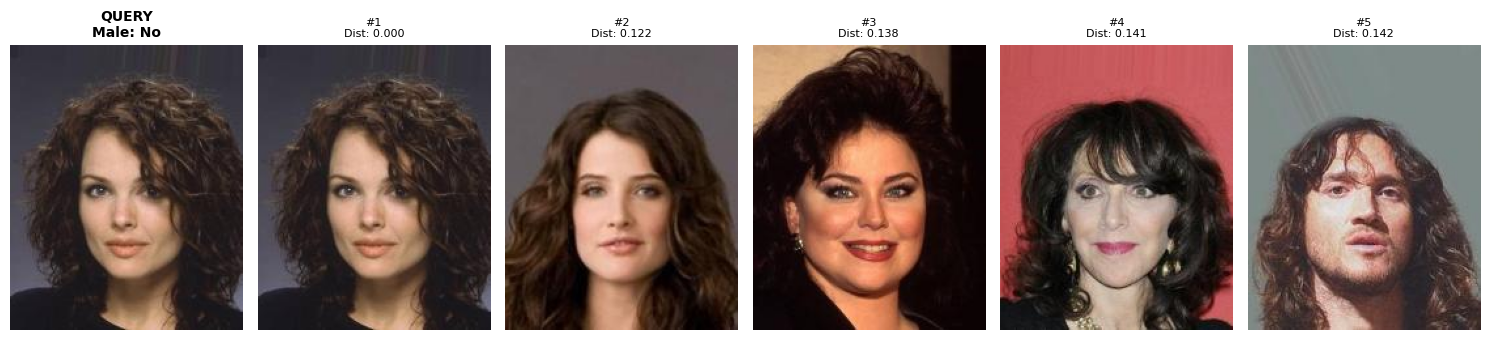

(['data/img_align_celeba/img_align_celeba/162771.jpg',
  'data/img_align_celeba/img_align_celeba/172220.jpg',
  'data/img_align_celeba/img_align_celeba/179713.jpg',
  'data/img_align_celeba/img_align_celeba/162851.jpg',
  'data/img_align_celeba/img_align_celeba/164235.jpg'],
 array([1.0360171e-07, 1.2212142e-01, 1.3800350e-01, 1.4111292e-01,
        1.4208959e-01], dtype=float32),
 array([    0,  9449, 16942,    80,  1464]),
 {'Male': 0, 'Target': 0},
 [{'Target': 0}, {'Target': 0}, {'Target': 0}, {'Target': 0}, {'Target': 1}])

In [12]:
query_path_face = face_dataset.image_paths[0]
face_search_and_visualize(model, face_index, query_path_face, face_dataset, device, k=5)